In hmvec, it will only find the power spectra of profiles defined within the model. You can only define profiles in the model by using the preset options or changing the parameters, of which there are many and they're complicated. There doesn't seem to be an option to find the power spectra of a given profile without defining it in the model using the parameters. To find the parameters of an already given profile you'd need to fit that profile using MCMC or something.

This notebook takes the functions used to get the power spectra and edits them so they take any profile WITHOUT the need for defining it with parameters. This is useful if the profile is simple, like just the total matter profile, which should just be the nfw and electron matter profiles added together. 

This could also be used to find the power spectra of profiles we get from data, which is the opposite of the fitting notebook, which seeks to obtain a profile by fitting to a power spectrum we might get in data, and is much simpler.

In [1]:
import os,sys
sys.path.append('../')
import camb
import hmvec as hm
import numpy as np
import matplotlib.pyplot as plt
# import emcee
# import corner
import time

In [2]:
# Create model
zs = np.linspace(0.,3.,20)  # 20
ms = np.geomspace(2e10,1e17,200)  # 200
ks = np.geomspace(1e-4,100,1001)  # 1001
hcos = hm.HaloModel(zs,ks,ms=ms)

xmax = 20  # 20
nxs = 5000  # 5000

In [3]:
# Create density profile
hcos.add_battaglia_profile("electron",family="AGN",xmax=xmax,nxs=nxs, ignore_existing=True)

# Use hmvec to get power spectra
pmm_1h = hcos.get_power_1halo(name="nfw")
pmm_2h= hcos.get_power_2halo(name="nfw")

pee_1h = hcos.get_power_1halo(name="electron")
pee_2h = hcos.get_power_2halo(name="electron")

/global/u2/c/cpopik/Packages/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [4]:
# Create pressure profile
hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

# Use hmvec to get power spectra
pyy_1h = hcos.get_power_1halo(name="y")
pyy_2h = hcos.get_power_2halo(name="y")

Check the consistency relation for tSZ
Check the consistency relation for tSZ


In [5]:
# Make some Cross Spectra
pme_1h = hcos.get_power_1halo("nfw","electron")
pme_2h = hcos.get_power_2halo("nfw","electron")

pmy_1h = hcos.get_power_1halo("nfw","y")
pmy_2h = hcos.get_power_2halo("nfw","y")

pey_1h = hcos.get_power_1halo("electron","y")
pey_2h = hcos.get_power_2halo("electron","y")

Check the consistency relation for tSZ
Check the consistency relation for tSZ


# New functions to get P for any profiles

In [6]:
def get_matter_alt(profile, lowklim=False):
    ms = hcos.ms[...,None]
    uk = profile
    if lowklim: uk = 1
    return ms*uk/hcos.rho_matter_z(0)

def get_pressure_alt(profile,lowklim=False):
    pk = profile.copy()
    if lowklim: pk[:,:,:] = pk[:,:,0][...,None]
    return pk

In [7]:
def get_power_1halo_alt(profile1, profiletype1, profile2, profiletype2):
    ms = hcos.ms[...,None]
    square_term=1.
    profiles = [profile1, profile2]
    profiletypes = [profiletype1, profiletype2]
    for i in [0, 1]:
        if profiletypes[i] == 'matter':
            square_term *= get_matter_alt(profiles[i])
        elif profiletypes[i] == 'pressure':
            square_term *= get_pressure_alt(profiles[i])
#         elif profiletypes[i]=='hod':
#             square_term *= get_hod_alt(profiles[i])
        else: raise ValueError
        
    integrand = hcos.nzm[...,None] * square_term
    return np.trapz(integrand,ms,axis=-2)*(1-np.exp(-(hcos.ks/hcos.p['kstar_damping'])**2.))

In [8]:
def get_power_2halo_alt(profile1, profiletype1, profile2, profiletype2,verbose=False,b1_in=None,b2_in=None):        
        def _2haloint(iterm):
            integrand = hcos.nzm[...,None] * iterm * hcos.bh[...,None]
            integral = np.trapz(integrand,ms,axis=-2)
            return integral

        def _get_term(profile, profiletype):
            if profiletype == 'matter':
                rterm1 = get_matter_alt(profile)
                rterm01 = get_matter_alt(profile,lowklim=True)
                b = 1
            elif profiletype == 'pressure':
                rterm1 = get_pressure_alt(profile)
                rterm01 = get_pressure_alt(profile,lowklim=True)
                print ('Check the consistency relation for tSZ')
                b = rterm01 =0
#             elif profiletype == 'hod':
#                 rterm1 = get_hod_alt(profile)
#                 rterm01 = get_hod_alt(profile,lowklim=True)
#                 b = self.get_bg(self.hods[iname]['Nc'],self.hods[iname]['Ns'],self.hods[iname]['ngal'])[:,None]
            else: raise ValueError
            return rterm1,rterm01,b
            
        ms = hcos.ms[...,None]


        iterm1,iterm01,b1 = _get_term(profile1, profiletype1)
        iterm2,iterm02,b2 = _get_term(profile2, profiletype2)
        if b1_in is not None:
            b1 = b1_in.reshape((b1_in.shape[0],1))
        if b2_in is not None:
            b2 = b2_in.reshape((b1_in.shape[0],1))

        integral = _2haloint(iterm1)
        integral2 = _2haloint(iterm2)
            
        # consistency relation : Correct for part that's missing from low-mass halos to get P(k->0) = b1*b2*Plinear
        consistency1 = _2haloint(iterm01)
        consistency2 = _2haloint(iterm02)
        if verbose:
            print("Two-halo consistency1: " , consistency1,integral)
            print("Two-halo consistency2: " , consistency2,integral2)
        return hcos.Pzk * (integral+b1-consistency1)*(integral2+b2-consistency2)

In [9]:
# Test to ensure that the new functions calculate correctly

test1_1h = get_power_1halo_alt(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.uk_profiles['nfw'], 'matter')
test1_2h = get_power_2halo_alt(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.uk_profiles['nfw'], 'matter')

test2_1h =get_power_1halo_alt(hcos.pk_profiles['y'], 'pressure', \
                               hcos.pk_profiles['y'], 'pressure')
test2_2h = get_power_2halo_alt(hcos.pk_profiles['y'], 'pressure', \
                               hcos.pk_profiles['y'], 'pressure')

test3_1h = get_power_1halo_alt(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.uk_profiles['electron'], 'matter')
test3_2h = get_power_2halo_alt(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.uk_profiles['electron'], 'matter')

test4_1h = get_power_1halo_alt(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.pk_profiles['y'], 'pressure')
test4_2h = get_power_2halo_alt(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.pk_profiles['y'], 'pressure')

np.count_nonzero(pmm_1h-test1_1h), np.count_nonzero(pmm_2h-test1_2h), \
np.count_nonzero(pyy_1h-test2_1h), np.count_nonzero(pyy_2h-test2_2h), \
np.count_nonzero(pme_1h-test3_1h), np.count_nonzero(pme_2h-test3_2h), \
np.count_nonzero(pmy_1h-test4_1h), np.count_nonzero(pmy_2h-test4_2h)

Check the consistency relation for tSZ
Check the consistency relation for tSZ
Check the consistency relation for tSZ


(0, 0, 0, 0, 0, 0, 0, 0)

In [10]:
test1_1h = hcos.get_power_1halo_custom(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.uk_profiles['nfw'], 'matter')
test1_2h = hcos.get_power_2halo_custom(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.uk_profiles['nfw'], 'matter')

test2_1h = hcos.get_power_1halo_custom(hcos.pk_profiles['y'], 'pressure', \
                               hcos.pk_profiles['y'], 'pressure')
test2_2h = hcos.get_power_2halo_custom(hcos.pk_profiles['y'], 'pressure', \
                               hcos.pk_profiles['y'], 'pressure')

test3_1h = hcos.get_power_1halo_custom(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.uk_profiles['electron'], 'matter')
test3_2h = hcos.get_power_2halo_custom(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.uk_profiles['electron'], 'matter')

test4_1h = hcos.get_power_1halo_custom(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.pk_profiles['y'], 'pressure')
test4_2h = hcos.get_power_2halo_custom(hcos.uk_profiles['nfw'], 'matter', \
                               hcos.pk_profiles['y'], 'pressure')

np.count_nonzero(pmm_1h-test1_1h), np.count_nonzero(pmm_2h-test1_2h), \
np.count_nonzero(pyy_1h-test2_1h), np.count_nonzero(pyy_2h-test2_2h), \
np.count_nonzero(pme_1h-test3_1h), np.count_nonzero(pme_2h-test3_2h), \
np.count_nonzero(pmy_1h-test4_1h), np.count_nonzero(pmy_2h-test4_2h)

Check the consistency relation for tSZ
Check the consistency relation for tSZ
Check the consistency relation for tSZ


(0, 0, 0, 0, 0, 0, 0, 0)

# Matter

In [10]:
pmeme_1h = get_power_1halo_alt(hcos.uk_profiles['nfw']+hcos.uk_profiles['electron'], 'matter', \
                               hcos.uk_profiles['nfw']+hcos.uk_profiles['electron'], 'matter')

pmeme_2h = get_power_2halo_alt(hcos.uk_profiles['nfw']+hcos.uk_profiles['electron'], 'matter', \
                               hcos.uk_profiles['nfw']+hcos.uk_profiles['electron'], 'matter')

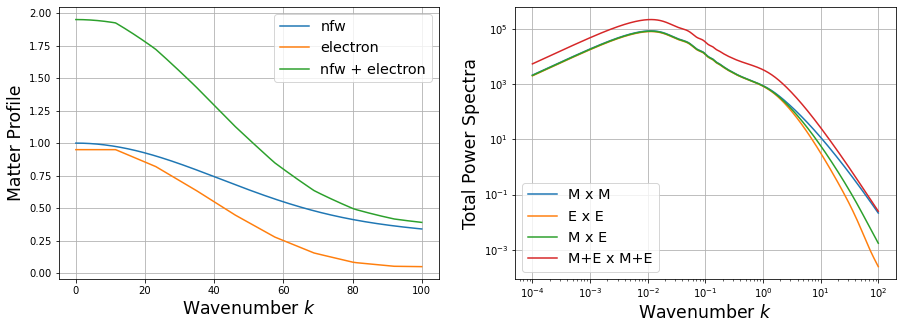

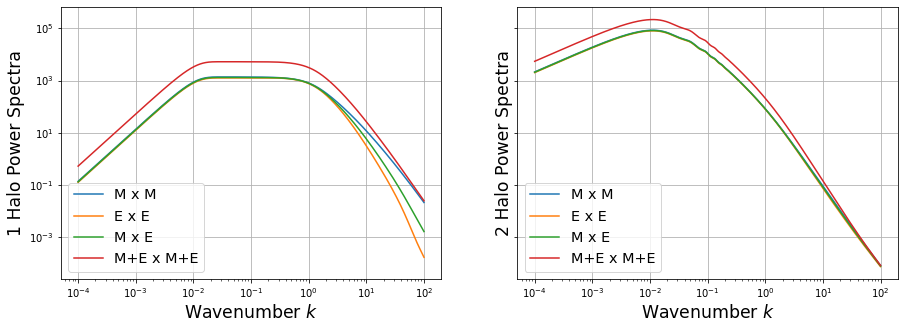

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.grid()
ax1.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax1.set_ylabel('Matter Profile', fontsize='xx-large')
for key in hcos.uk_profiles.keys():
    ax1.plot(ks, hcos.uk_profiles[key][0,0], label=key)
ax1.plot(ks, hcos.uk_profiles['nfw'][0,0]+hcos.uk_profiles['electron'][0,0], label='nfw + electron')
ax1.legend(fontsize='x-large')

ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax2.set_ylabel('Total Power Spectra', fontsize='xx-large')
ax2.plot(ks, pmm_1h[0]+pmm_2h[0], label='M x M')
ax2.plot(ks, pee_1h[0]+pee_2h[0], label='E x E')
ax2.plot(ks, pme_1h[0]+pme_2h[0], label='M x E')
ax2.plot(ks, pmeme_1h[0]+pmeme_2h[0], label='M+E x M+E')
ax2.legend(fontsize='x-large')

plt.show()


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax3.grid()
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax3.set_ylabel('1 Halo Power Spectra', fontsize='xx-large')
ax3.plot(ks, pmm_1h[0], label='M x M')
ax3.plot(ks, pee_1h[0], label='E x E')
ax3.plot(ks, pme_1h[0], label='M x E')
ax3.plot(ks, pmeme_1h[0], label='M+E x M+E')
ax3.legend(fontsize='x-large')

ax4.grid()
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax4.set_ylabel('2 Halo Power Spectra', fontsize='xx-large')
ax4.plot(ks, pmm_2h[0], label='M x M')
ax4.plot(ks, pee_2h[0], label='E x E')
ax4.plot(ks, pme_2h[0], label='M x E')
ax4.plot(ks, pmeme_2h[0], label='M+E x M+E')
ax4.legend(fontsize='x-large')

plt.show()

# Pressure

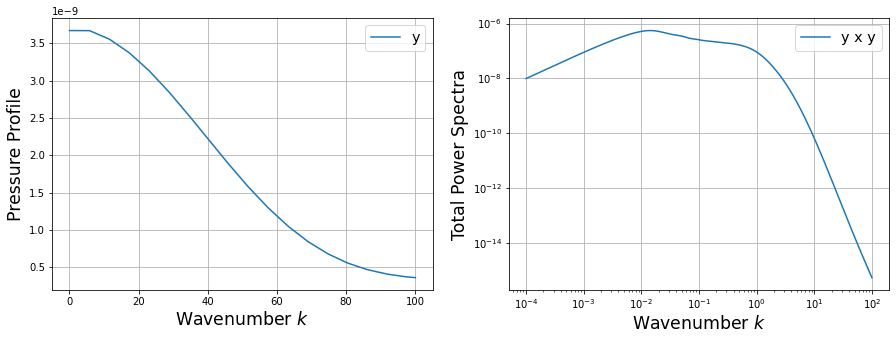

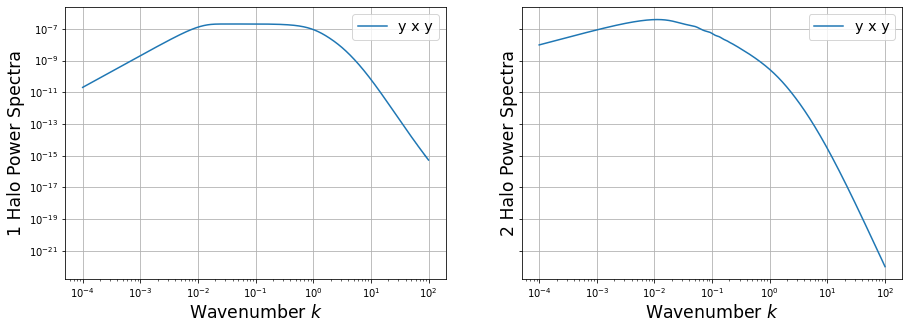

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.grid()
ax1.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax1.set_ylabel('Pressure Profile', fontsize='xx-large')
for key in hcos.pk_profiles.keys():
    ax1.plot(ks, hcos.pk_profiles[key][0,0], label=key)
ax1.legend(fontsize='x-large')

ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax2.set_ylabel('Total Power Spectra', fontsize='xx-large')
ax2.plot(ks, pyy_1h[0]+pyy_2h[0], label='y x y')
ax2.legend(fontsize='x-large')

plt.show()


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax3.grid()
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax3.set_ylabel('1 Halo Power Spectra', fontsize='xx-large')
ax3.plot(ks, pyy_1h[0], label='y x y')
ax3.legend(fontsize='x-large')

ax4.grid()
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax4.set_ylabel('2 Halo Power Spectra', fontsize='xx-large')
ax4.plot(ks, pyy_2h[0], label='y x y')
ax4.legend(fontsize='x-large')

plt.show()

# Cross-Spectra between Matter and Pressure

In [13]:
pmey_1h = get_power_1halo_alt(hcos.uk_profiles['nfw']+hcos.uk_profiles['electron'], 'matter', \
                               hcos.pk_profiles['y'], 'pressure')

pmey_2h = get_power_2halo_alt(hcos.uk_profiles['nfw']+hcos.uk_profiles['electron'], 'matter', \
                               hcos.pk_profiles['y'], 'pressure')

Check the consistency relation for tSZ


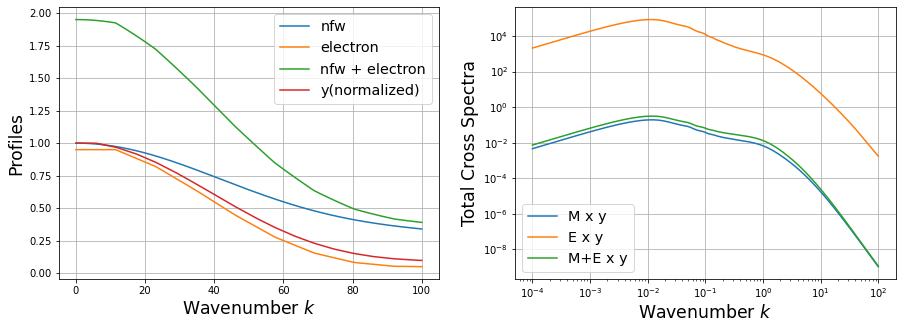

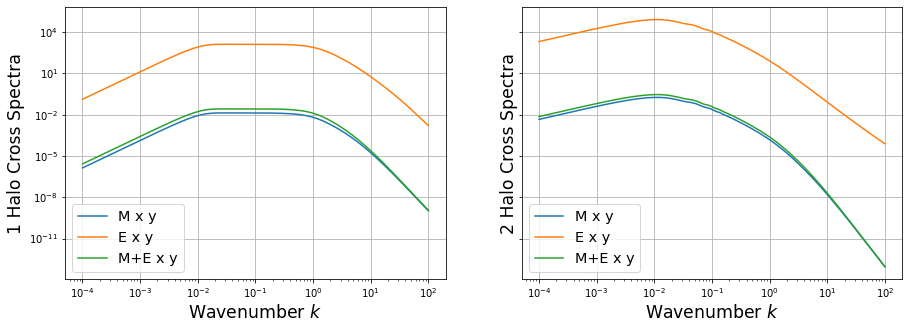

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.grid()
ax1.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax1.set_ylabel('Profiles', fontsize='xx-large')
for key in hcos.uk_profiles.keys():
    ax1.plot(ks, hcos.uk_profiles[key][0,0], label=key)
ax1.plot(ks, hcos.uk_profiles['nfw'][0,0]+hcos.uk_profiles['electron'][0,0], label='nfw + electron')
for key in hcos.pk_profiles.keys():
    ax1.plot(ks, hcos.pk_profiles[key][0,0]/max(hcos.pk_profiles[key][0,0]), label=key+'(normalized)')
ax1.legend(fontsize='x-large')

ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax2.set_ylabel('Total Cross Spectra', fontsize='xx-large')
ax2.plot(ks, pmy_1h[0]+pmy_2h[0], label='M x y')
ax2.plot(ks, pme_1h[0]+pme_2h[0], label='E x y')
ax2.plot(ks, pmey_1h[0]+pmey_2h[0], label='M+E x y')
ax2.legend(fontsize='x-large')

plt.show()


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax3.grid()
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax3.set_ylabel('1 Halo Cross Spectra', fontsize='xx-large')
ax3.plot(ks, pmy_1h[0], label='M x y')
ax3.plot(ks, pme_1h[0], label='E x y')
ax3.plot(ks, pmey_1h[0], label='M+E x y')
ax3.legend(fontsize='x-large')

ax4.grid()
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax4.set_ylabel('2 Halo Cross Spectra', fontsize='xx-large')
ax4.plot(ks, pmy_2h[0], label='M x y')
ax4.plot(ks, pme_2h[0], label='E x y')
ax4.plot(ks, pmey_2h[0], label='M+E x y')
ax4.legend(fontsize='x-large')

plt.show()